In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.84
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 0.83


**seu_ns: SEU-Allen's data**

**all_ns: SEU + Janelia's data**

Input .swc data file, total **1602**.

In [2]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

ns = nmt.neuron_set('/home/penglab/FeaCal/allData')
pickle.dump([ns], open("/home/penglab/FeaCal/all_ns.pickle", "wb"))

# 2.1) Distribution of soma location
* Set the *thre* value to determine the threshold for showing the region distribution
* mouseDF is a dataframe recording the ['Child ID', 'Child num', 'ABBR', 'FatherRe'] of 1327 brain regions
* Not going to write mouseDF to the pkg, just to show the result

## 2.1.1) Based on 7 regions
* including Isocortex, OLF, HPF, CTXsp, CNU, BS, CB; 


In [4]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

somaRegDF = ns.features['soma_features'].region.copy()
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
somaRegDF['main7Region'] = somaRegDF['Region']     
for iterR in somaRegDF.index:
    if somaRegDF.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        somaRegDF.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==somaRegDF.loc[iterR,'Region']].iloc[0,-1]

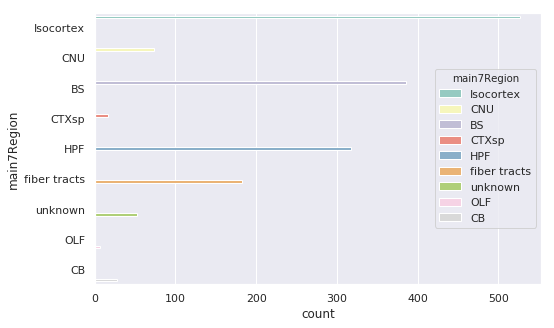

In [5]:
ct = somaRegDF["main7Region"].value_counts().sort_values(ascending=False)
thre = 0
sns.set(rc={'figure.figsize':(8,5)})
_ = sns.countplot(y="main7Region", 
                  data=somaRegDF.loc[somaRegDF.main7Region.isin(ct.index[ct>thre])],
                  hue = "main7Region", palette="Set3"
                 )


## 2.1.2) Projecting to three directions: "Horizontal","Coronal","Sagittal"

**2.1.2.1) By setting color="majorSOMA" in cell_in_map, the soma point will be shown with 7 major regions**
* Here set the 'Cluster' column in ns.metadata to be the region name.

**2.1.2.2) By setting color="soma" in cell_in_map, the soma point will be shown with 256 colors**
* No need to set the 'Cluster' column in ns.metadata to be the region name.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
    from neuro_morpho_toolbox.plot import cell_in_map
    fig, ax = plt.subplots(3,1, figsize=(7.5, 10))
    cur_list = ns.metadata.index.tolist()
    cell_in_map(ns.neurons, cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="soma",alpha=1,ax=ax[0])
    cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation, 
                view="Coronal", color="soma", alpha=1,ax=ax[1])
    cell_in_map(ns.neurons,cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Sagittal", color="soma", alpha=1, ax=ax[2])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```

**2.1.2.1)  Plot singel view('Horizontal') with only 7 major regions**

Illustrating soma locations inside a brain from horizontal view:


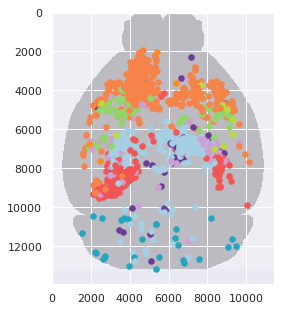

In [6]:
from neuro_morpho_toolbox.plot import cell_in_map
fig, ax =  plt.subplots(1,1)
cur_list = ns.metadata.index.tolist()
somaRegDF['Cluster']= somaRegDF.loc[:,'main7Region']
somaRegDF
cell_in_map(ns.neurons, cur_list, somaRegDF,ccf_annotation=nmt.annotation,view="Horizontal",color="majorsoma",ax=ax
           )
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

**2.1.2.2) Plot singel view('Horizontal') with all regions**

Illustrating soma locations inside a brain from horizontal view:


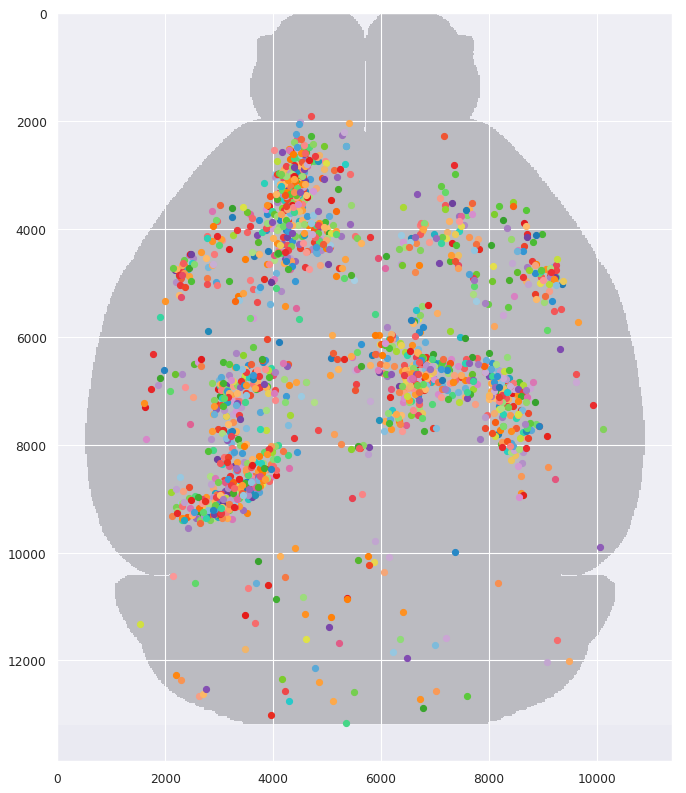

In [7]:
from neuro_morpho_toolbox.plot import cell_in_map
cur_list = ns.metadata.index.tolist()
somaRegDF
cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation,view="Horizontal", color="soma")
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

## 2.1.3) Use wordcloud to illustrate the information
* Not going to write into the pkg just to show the result

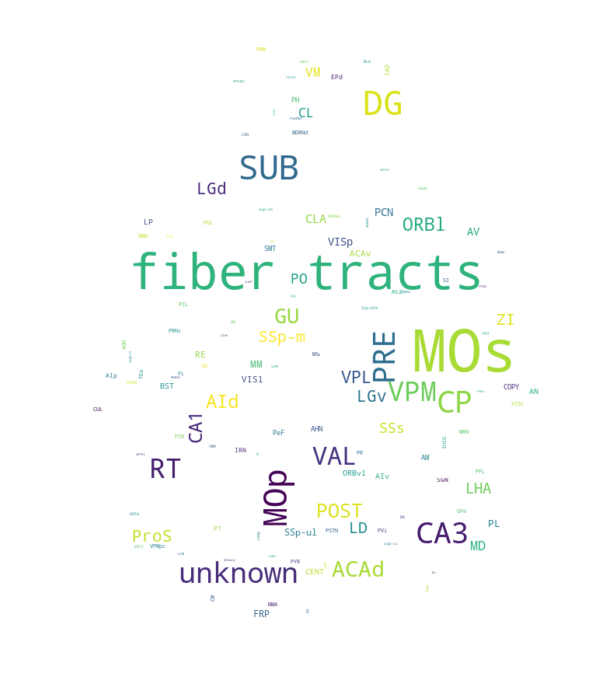

In [8]:
import jieba               
from wordcloud import WordCloud   
from PIL import Image
img = np.array(Image.open("/home/penglab/Desktop/mask.png"))
region_all, count = np.unique(somaRegDF['Region'], return_counts=True)
somaDIC = {}
for i in range(len(region_all)):
    #if region_all[i] == 'fiber tracts':
        #continue
    somaDIC[region_all[i]] = count[i]

wc = WordCloud(background_color='white',width=240,height=160,max_font_size=75,min_font_size=5,
               colormap="viridis", mask = img)
wc.generate_from_frequencies(somaDIC)
#save the file
wc.to_file('/home/penglab/Desktop/WC.png') 
# Show the plot
plt.figure(figsize=(10,20)) 
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()


## 1.1) Analyze soma location to obtain confident list

**Read the downsample-25 array with selected CCF region**

<blockquote>Example
    
```Python
nmt.ccfArray
```
</blockquote>

**Read the 6-nearest neighbor Contour Matrix with CCF index on**

* Originally, selected CCF has *316* regions, after using all the selected index to replace the child region, there are *337* regions.
* Therefore, there are 23 regions that show up in the nrrd array but have not been mentioned in the above selected CCF or its child region

<blockquote>Example
    
```Python
nmt.Contour01
```
</blockquote>

***Use nmt.disCal to obtain a DataFrame with columns ['x', 'y', 'z', 'SqEuclidean', 'min_Euclidean']***

<blockquote>Example
</blockquote>

```Python
    somaDis = nmt.disCal(ns.features['soma_features'].raw_data,
                         CCF_6_01,ccfArray, 10, flipF = True)
```


In [11]:
pickle_in = open("/home/penglab/NMTcode/somaDis.pickle","rb")
example_ = pickle.load(pickle_in)
somaDis = example_[0]

SelectedDF is obtained by throwing the unknown region and fiber tracts soma away

In [12]:
selectedDF = somaDis[somaDis['SqEuclidean'] != 'unknown'].copy()
selectedDF = selectedDF[selectedDF['Region'] != 'fiber tracts'].copy()
confi_list = selectedDF.index.tolist()
print('Number of confident neurons are '+ str(len(confi_list)))
se_list = selectedDF.index.tolist()

Number of confident neurons are 1006


## Calculate ARI according to a given list

### Generate the dataframe using pickCLUSTERpara(method)

<blockquote>Example</blockquote>

```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy',se_list)
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans',se_list)
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan',se_list)
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan',se_list)
    snn_resultDF = ns.pickCLUSTERpara('snn',se_list)
```
or if want to calculate ARI for all neurons, just use
```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy')
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans')
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan')
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan')
    snn_resultDF = ns.pickCLUSTERpara('snn')
```

### Print out the most proper parameter by maximizing ARI

<blockquote>Example</blockquote>

```Python
    hierbest = findBESTpara(hier_resultDF,[15,45],16)
    kmeansbest = findBESTpara(kmeans_resultDF,[15,45],16)
    dbscanbest = findBESTpara(dbscan_resultDF,[15,45],16)
    hdbscanbest = findBESTpara(hdbscan_resultDF,[15,45],16)
    snnbest = findBESTpara(snn_resultDF,[15,45],16)
```

## Using co-clustering towards the selected parameters

### function freq_Matrix(fre_M, cluster_method,para_test)
* **fre_M** is the square DataFrame recording the number of co-clustering
* **cluster_method** can be 'Hierarchy','Kmeans', 'DBSCAN','HDBSCAN','SNN_community'
* **para_test** is the input parameter dictionary for the cluster method
* **iternum** is the number of iteration to generate the coclustering matrix
    
* *Return an array*

## Feature 1: projection patterns

In [13]:
AP_hierDF = pd.read_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx', index_col=0)
AP_kmeansDF = pd.read_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx', index_col=0)
AP_dbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx', index_col=0)
AP_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx', index_col=0)
AP_snnDF = pd.read_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx', index_col=0)

## Feature 2: Soma Location

In [16]:
SL_hierDF = pd.read_excel('/home/penglab/NMTcode/SL_hier_co_cluster.xlsx', index_col=0)
SL_kmeansDF = pd.read_excel('/home/penglab/NMTcode/SL_kmeans_co_cluster.xlsx', index_col=0)
SL_dbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_dbscan_co_cluster.xlsx', index_col=0)
SL_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_hdbscan_co_cluster.xlsx', index_col=0)
SL_snnDF = pd.read_excel('/home/penglab/NMTcode/SL_snn_co_cluster.xlsx', index_col=0)

In [17]:

from scipy.spatial import distance
from scipy.cluster import hierarchy
import numpy as np

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster,inconsistent
#print the cocluster result
#output the linkage matrix
def bestCOCLUSTER(df,axis_color,input_ns = None):
    linkmethod = ['single', 'complete','average','weighted','centroid','median','ward']
    paraDF = pd.DataFrame(columns =['method','CCC'],index = linkmethod)
    paraDF.loc[:,'method'] = linkmethod
    
    for iter_m in linkmethod:
        Y = distance.pdist(np.asarray(df))
        Z = hierarchy.linkage(Y, method = iter_m)
        c, coph_dists = hierarchy.cophenet(Z,Y)
        paraDF.loc[iter_m,'cophentic_correlation_dis'] = c
    paraDF.sort_values(by='cophentic_correlation_dis', ascending = False, inplace = True)
    # choose the linkage method which maximizes the cophentic correlation distance
    if type(axis_color) == dict:
        colorDF = pd.DataFrame(index = ns.metadata.index,data = ns.metadata['CellType'], columns = ['CellType'])
        for iter_idx in colorDF.index:
            colorDF.loc[iter_idx,'Color'] = axis_color[colorDF.loc[iter_idx,'CellType']]
        axis_color = colorDF['Color']
    row_linkage = hierarchy.linkage(distance.pdist(np.asarray(df)), method = paraDF.iloc[0,0])
    col_linkage = hierarchy.linkage(distance.pdist(np.asarray(df).T), method = paraDF.iloc[0,0])
    #print(paraDF.iloc[0,0])
    sns.clustermap(df, row_linkage = row_linkage, col_linkage = col_linkage, row_colors=axis_color,
                   col_colors = axis_color)#, figsize=(13, 13))#, cmap=sns.diverging_palette(h_neg=150, h_pos=275, s=80, l=55, as_cmap=True))    
    return hierarchy.linkage(distance.pdist(np.asarray(df)))



def coclusterResult(Z_sample):
    t = input('Please input the number of cluster: ')
    return fcluster(Z_sample,t,criterion='maxclust')

In [29]:

def get_group_colors2(metadata, group_by="CellType", palette="paired", return_str=False, return_hex = False):
    assert group_by in metadata.columns.tolist(), "Invalid group_by value."
    assert palette in list(my_palette_dict.keys()), "Invalid palette name."
    u_groups = sorted(list(set(metadata[group_by])))
    color_list = cl.to_rgb(cl.interp(my_palette_dict[palette], len(u_groups)))
    if return_str and return_hex:
        color_list = [rgb_to_hex(i) for i in color_list]
    if not return_str:
        color_list = [rgb_to_list(i) for i in color_list]
        
    group_colors = dict(zip(u_groups, color_list))
    if "Others" in u_groups:
        if not return_str:
            group_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
        elif return_str and return_hex:
            group_colors["Others"] = '#808080'
        else:
            group_colors["Others"] = 'rgb(128, 128, 128)'
    return group_colors

In [32]:
import matplotlib as mpl
from colormap import rgb2hex
bupu = cl.scales['9']['seq']['BuPu']           
greens = cl.scales['9']['seq']['Greens']        
set2 = cl.scales['7']['qual']['Set2']           
spectral = cl.scales['9']['div']['Spectral']   
paired = cl.scales['10']['qual']['Paired']     
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(mpl.colors.to_rgb("C" + str(i))):
        tp.append(str(int(j * 255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i) / 255 for i in tp.split(", ")]
    return res

def rgb_to_hex(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    hex = rgb2hex(int(list(tp.split(", "))[0]),int(list(tp.split(", "))[1]),int(list(tp.split(", "))[2]))
    return hex
DDD =get_group_colors2(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True)

array([[1.42800000e+03, 1.46200000e+03, 2.96339333e+02, 2.00000000e+00],
       [1.56400000e+03, 1.56900000e+03, 3.06003268e+02, 2.00000000e+00],
       [1.57100000e+03, 1.58800000e+03, 3.06555052e+02, 3.00000000e+00],
       ...,
       [3.16300000e+03, 3.16900000e+03, 2.91500481e+04, 1.31300000e+03],
       [3.13200000e+03, 3.17000000e+03, 3.31352227e+04, 1.46300000e+03],
       [3.14300000e+03, 3.17100000e+03, 3.33637587e+04, 1.58700000e+03]])

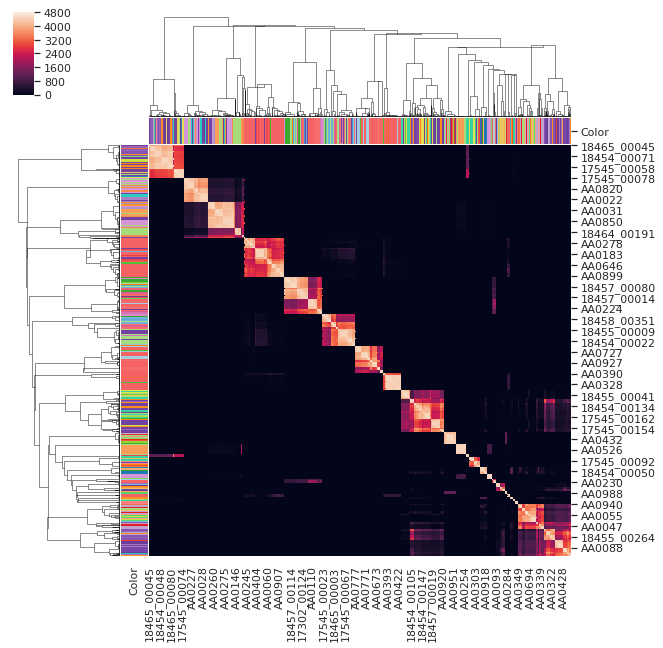

In [33]:

bestCOCLUSTER(SL_snnDF,DDD,ns)

In [ ]:
import seaborn as sns; sns.set()




colorlist=["#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#666666","#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
           "#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#FBB4AE","#B3CDE3",
           "#CCEBC5","#DECBE4","#FED9A6","#FFFFCC","#E5D8BD","#FDDAEC","#F2F2F2","#B3E2CD","#FDCDAC","#CBD5E8",
           "#F4CAE4","#E6F5C9","#FFF2AE","#F1E2CC","#CCCCCC","#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00",
           "#FFFF33","#A65628","#F781BF","#999999","#66C2A5","#FC8D62","#8DA0CB","#E78AC3","#A6D854","#FFD92F",
           "#E5C494","#B3B3B3","#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
           "#D9D9D9","#BC80BD","#CCEBC5"]
lut = dict(zip(ns.metadata['CellType'].unique(), colorlist))
row_colors = ns.metadata['CellType'].map(lut)
row_colors[row_colors.isnull()]='white'

In [ ]:
row_colors[0:6]

In [ ]:
DDD=(nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str=False, return_colorCode = ))
bestCOCLUSTER(SL_snnDF,DDD,ns)

In [ ]:
bestCOCLUSTER(SL_snnDF,DDD,ns)

In [ ]:
stoppp

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
hierarchy.linkage(distance.pdist(np.asarray(SL_snnDF)), method = 'single')

In [ ]:
Ztemp= bestCOCLUSTER(DM_hierDF)


In [ ]:
import pickle
def generateNS(featureDF,ns_input,Z_sample,storePath,outname):
    if featureDF.shape!= (0,0):
        pickle_in = open("/home/penglab/FeaCal/ns.pickle","rb")
        example_ = pickle.load(pickle_in)
        ns_input= example_[0]

        index_origin = ns_input.metadata.index.tolist()
        ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, 
                                         metric='euclidean',PCA_first=True,n_PC=100)
        index_after = ns_input.UMAP.index.tolist()
        if len(index_after)>len(index_origin ):
            index_update = [i for i in index_after if i in index_origin ]
        else:
            index_update = [i for i in index_origin if i in index_after ]
        
        ns_input.metadata = ns_input.metadata.loc[index_update,:]
    cur_clusters = coclusterResult(Z_sample)
    ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters] 
    _ = ns_input.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")
    return ns_input

In [ ]:
AP_hierDF  = DM_hierDF

In [ ]:
Ztemp= bestCOCLUSTER(AP_hierDF)
generateNS(pd.DataFrame(),ns,Ztemp,'/home/penglab/FeaCal/','AP_hier_ns')

In [ ]:
_ = ns.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")

In [ ]:
DM_kmeans = para_cocluster('Kmeans', par_kmeans2,30, 5000,ns)
DM_kmeansDF = pd.DataFrame(data=DM_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
DM_kmeansDF.to_excel('/home/penglab/FeaCal/dataSource/denMor/DM_kmeansDF.xlsx')



In [ ]:
# df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.xlsx", index_col=[0])
# metadata = ns.features['soma_features'].region
# df = df.loc[metadata.index]
# df.to_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.284_cells.xlsx")

In [ ]:
df = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
pickle.dump([metadata], open("metadata.pickle", "wb"))

## Color setting

In [ ]:
bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(matplotlib.colors.to_rgb("C"+str(i))):
        tp.append(str(int(j*255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
   
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_celltype_colors(metadata):
    u_celltypes = sorted(list(set(metadata.Celltype)))
    color_list = cl.to_rgb(cl.interp(paired, len(u_celltypes)))
    color_list = [rgb_to_list(i) for i in color_list]
    celltype_colors = dict(zip(u_celltypes, color_list))
    if "Others" in u_celltypes:
        celltype_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return celltype_colors

celltype_color_dict = get_celltype_colors(metadata)

pickle.dump([celltype_color_dict], open("colors.pickle", "wb"))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,8))
for i, key in enumerate(list(celltype_color_dict.keys())):
    ax.scatter(0.001, len(celltype_color_dict) - i, c=celltype_color_dict[key], s=100)
    ax.text(0.002, len(celltype_color_dict) - i, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
    ax.set_xlim(0, 0.01)
    ax.axis("off")

In [ ]:
ns.metadata["CellType"] = metadata.loc[ns.metadata.index, "Celltype"]
clusters = pd.read_csv("clusters.csv", index_col=[0])
ns.metadata['Cluster'] = clusters.loc[ns.metadata.index, "Cluster"]
ns.metadata["CellType_note"] = metadata.loc[ns.metadata.index, "Celltype_note"]

In [ ]:
pickle.dump([ns], open("neuron_set.pickle", "wb"))

In [ ]:
ns.features['projection_features'].normalize(log=True)
pickle.dump([ns.features['projection_features']], open("features_projection.pickle", "wb"))

In [ ]:
ns.features['projection_features'].scaled_data

## Feature 2: soma locations

In [ ]:
pickle.dump([ns.features['soma_features']], open("features_soma.pickle", "wb"))

## Feature 3: axon morphological features

In [ ]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [ ]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [ ]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

## Feature 4: dendrite morphological features

In [ ]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

In [ ]:
print(np.log(10000), np.log(5000))